## AEMET dataset


Este conjunto de datos recoge información sobre la temperatura en cada hora en varios días en una estación meteorológica describiendo las condiciones del momento evaluado. Los atributos son:

<ul>
<li>Fecha y hora oficial: momento de la recogida de los datos.
<li>Velocidad del viento (km h): velocidad del viento en ese momento, medido en km/h.
<li>Dirección del viento: dirección a la que se dirigía el viento.
<li>Racha (km h): velocidad de la racha en km/h.
<li>Dirección de racha: dirección a la que se dirigía la racha.
<li>Humedad (%): porcentaje de humedad en ese momento.
<li>Temp: temperatura medida en ese momento. Clase a prededir.
<li>Precip: cantidad de precipitaciones en ese momento, en mm/m^2.
<li>PresAtm: presión atmosferica en el momento evaluado, en hPa.
<li>Tend: tendencia de la temperatura.

</ul>



In [22]:
import sys
import pandas as pd
from pandas import read_csv
import numpy
from numpy import array
import matplotlib.pyplot as plt
import math
import tensorflow
import keras
import sklearn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from google.colab import drive
import numpy as np


# Variables iniciales
Historia=1
EPOCAS=5
BATCHSIZE=1
LSTM_dim=1

In [23]:
print (sys.version_info)
print ("NumPy: ", numpy.__version__)
print ("Pandas: ", pd.__version__)
print ("TensorFlow: ", tensorflow.__version__)
print ("Keras: ", keras.__version__)
print ("SciKitLearn: ", sklearn.__version__)


sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)
NumPy:  1.25.2
Pandas:  2.0.3
TensorFlow:  2.15.0
Keras:  2.15.0
SciKitLearn:  1.2.2


## Carga de los datos

In [94]:
# Leer el excel
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/proyecto-tensorflow/buenos/AEMET-2019.xlsx'
dfAEMETVa=pd.read_excel (path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Imprimir las columnas
print(dfAEMETVa.columns)

Index(['Fecha y hora oficial', 'Velocidad del viento (km h)',
       'Dirección del viento', 'Racha (km h)', 'Dirección de racha',
       'Humedad (%)', 'Temp', 'Precip', 'PresAtm', 'Tend'],
      dtype='object')


In [26]:
# Renombrar las columnas
dfAEMETVa.rename(columns = {'Fecha y hora oficial':'FechaHora', 'Velocidad del viento (km h)':'VelV',
                     'Dirección del viento':"DirV", 'Racha (km h)':'VelRacha', 'Dirección de racha':'DirRacha',
                     'Humedad (%)':'Humedad'}, inplace=True)

# Ordenar por fecha y hora
dfAEMETVa.sort_values(['FechaHora'], inplace=True)

In [27]:
# Contar el número de valores nulos por columna
valores_nulos_por_columna = dfAEMETVa.isnull().sum()

# Mostrar el resultado
print(valores_nulos_por_columna)

FechaHora    0
VelV         0
DirV         0
VelRacha     0
DirRacha     0
Humedad      0
Temp         0
Precip       0
PresAtm      0
Tend         0
dtype: int64


In [28]:
# No es necesario, porque no hay nulos
dfAEMETVa.dropna(inplace=True)
dfAEMETVa

,FechaHora,VelV,DirV,VelRacha,DirRacha,Humedad,Temp,Precip,PresAtm,Tend
0,2019-12-05 14:00:00.000,6,Nordeste,22,Nordeste,66,10.7,0.0,934.1,-0.4
1,2019-12-05 15:00:00.000,8,Nordeste,26,Norte,63,10.9,0.0,934.0,-0.9
2,2019-12-05 16:00:00.000,8,Nordeste,22,Este,65,10.5,0.0,933.7,-0.4
3,2019-12-05 17:00:00.000,7,Norte,28,Norte,68,9.6,0.0,934.1,0.0
4,2019-12-05 18:00:00.000,5,Norte,21,Nordeste,73,8.5,0.0,934.5,0.5
...,...,...,...,...,...,...,...,...,...,...
3205,2020-04-27 07:00:00.000,8,Oeste,17,Oeste,87,9.8,0.0,926.3,-0.4
3206,2020-04-27 08:00:00.000,6,Sudoeste,17,Oeste,92,9.4,0.2,926.3,-0.1
3207,2020-04-27 09:00:00.000,8,Sudoeste,17,Oeste,90,10.0,0.0,926.5,0.4
3208,2020-04-27 10:00:00.000,9,Oeste,24,Oeste,85,10.4,0.0,926.7,0.4


## Funciones

In [73]:
'''
sequence = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n_steps = 3

X:
[[1 2 3]
 [2 3 4]
 [3 4 5]
 [4 5 6]
 [5 6 7]
 [6 7 8]
 [7 8 9]]

y:
[ 4  5  6  7  8  9 10]

X: Cada fila de X es una subsecuencia de 3 pasos de la secuencia original.
y: Cada elemento de y es el valor que sigue inmediatamente a la correspondiente subsecuencia en X.


'''
def CreaDatos(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)): # Recorrer la secuencia
        end_ix = i + n_steps # Establecer el límite
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix] # Extrae secuencia de entrada y valor objetivo
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)



def Visualiza (titulo2):
    # Desnormaliza
    testPredict = model.predict(testX, batch_size=BATCHSIZE)*(MaxRealY - MinRealY) + MinRealY
    testReal=testY[:,3]*(MaxRealY - MinRealY) + MinRealY

    # RMSE
    testScore = math.sqrt(mean_squared_error(testReal, testPredict.reshape(-1,1)))
    print('Test Score: %.2f RMSE' % (testScore))

    plt.plot (testPredict[0:240], label="Predic")
    plt.plot (testReal[0:240], label="Real")
    plt.legend ()
    plt.title ("Prediccion de temperatura a 1 hora.\n"+titulo2+" Historia="+str (Historia)+" Epocas="+str (EPOCAS)+ " LSTM_dim="+str (LSTM_dim))
    plt.show()
    return



## Preparación de datos

In [30]:
# Selección de columnas
df = dfAEMETVa.iloc [:,[1,3,5,6,7,8]]

In [31]:
# Para escalar
MinRealY=df["Temp"].min()
MaxRealY=df["Temp"].max()

In [56]:
print(MinRealY)
print(MaxRealY)

-4.2
24.0


In [32]:
print(df)

      VelV  VelRacha  Humedad  Temp  Precip  PresAtm
0        6        22       66  10.7     0.0    934.1
1        8        26       63  10.9     0.0    934.0
2        8        22       65  10.5     0.0    933.7
3        7        28       68   9.6     0.0    934.1
4        5        21       73   8.5     0.0    934.5
...    ...       ...      ...   ...     ...      ...
3205     8        17       87   9.8     0.0    926.3
3206     6        17       92   9.4     0.2    926.3
3207     8        17       90  10.0     0.0    926.5
3208     9        24       85  10.4     0.0    926.7
3209    11        23       73  11.6     0.0    926.9

[3210 rows x 6 columns]


In [92]:
# Ver los valores de las filas que van para el conjunto de test
tamano_test=int(len(df) * 0.67)
df.loc[:len(df)-tamano_test]

,VelV,VelRacha,Humedad,Temp,Precip,PresAtm
0,6,22,66,10.7,0.0,934.1
1,8,26,63,10.9,0.0,934.0
2,8,22,65,10.5,0.0,933.7
3,7,28,68,9.6,0.0,934.1
4,5,21,73,8.5,0.0,934.5
...,...,...,...,...,...,...
1056,2,6,92,2.9,0.0,933.0
1057,2,5,92,3.2,0.0,932.8
1058,2,5,93,3.0,0.0,932.7
1059,2,5,94,3.0,0.0,932.8


In [49]:
# Normalizar
scaler  = MinMaxScaler ()
dataset = scaler.fit_transform(df)

In [50]:
dataset

array([[0.15789474, 0.24358974, 0.55844156, 0.52836879, 0.        ,
        0.63571429],
       [0.21052632, 0.29487179, 0.51948052, 0.53546099, 0.        ,
        0.63333333],
       [0.21052632, 0.24358974, 0.54545455, 0.5212766 , 0.        ,
        0.62619048],
       ...,
       [0.21052632, 0.17948718, 0.87012987, 0.5035461 , 0.        ,
        0.4547619 ],
       [0.23684211, 0.26923077, 0.80519481, 0.5177305 , 0.        ,
        0.45952381],
       [0.28947368, 0.25641026, 0.64935065, 0.56028369, 0.        ,
        0.46428571]])

In [35]:
# Conjunto se divide entre entrenamiento y prueba.
train_size = int(len(df) * 0.67)
test_size  = len(df) - train_size
train = dataset[0:train_size,:]
test  = dataset[train_size:len(df),:]

In [36]:
# Preparar datos
print(train)

[[0.22631579 0.29487179 0.54675325 0.52269504 0.1        0.60857143]
 [0.26842105 0.33589744 0.51558442 0.52836879 0.1        0.60666667]
 [0.26842105 0.29487179 0.53636364 0.51702128 0.1        0.60095238]
 ...
 [0.16315789 0.16153846 0.76493506 0.31276596 0.1        0.63714286]
 [0.16315789 0.15128205 0.77532468 0.29858156 0.1        0.63142857]
 [0.16315789 0.14102564 0.7961039  0.28156028 0.1        0.62952381]]


In [37]:
# Preparar datos
trainX, trainY = CreaDatos(train, Historia)
testX, testY   = CreaDatos(test, Historia)


In [38]:
print(trainY)

[[0.26842105 0.33589744 0.51558442 0.52836879 0.1        0.60666667]
 [0.26842105 0.29487179 0.53636364 0.51702128 0.1        0.60095238]
 [0.24736842 0.35641026 0.56753247 0.49148936 0.1        0.60857143]
 ...
 [0.16315789 0.16153846 0.76493506 0.31276596 0.1        0.63714286]
 [0.16315789 0.15128205 0.77532468 0.29858156 0.1        0.63142857]
 [0.16315789 0.14102564 0.7961039  0.28156028 0.1        0.62952381]]


## LSTM para un problema de regresión



Si se utiliza una ventana temporal de longitud 1 para una red LSTM, significa que cada paso de tiempo del modelo verá solo un valor de la secuencia de datos a la vez para predecir el siguiente valor en la secuencia. En otras palabras, cada entrada al modelo será un único valor y el modelo tratará de predecir el valor siguiente basado únicamente en este único valor previo.

Una LSTM (Long Short-Term Memory) es un tipo de red neuronal recurrente (RNN) diseñada para modelar y predecir secuencias de datos temporales, superando las limitaciones de las RNN tradicionales en cuanto al manejo de dependencias a largo plazo. Las LSTM están compuestas por células que contienen tres puertas (de entrada, de salida y de olvido) que regulan el flujo de información, permitiendo que las LSTM mantengan y actualicen la memoria de manera eficiente. Esto las hace particularmente efectivas para tareas como la predicción de series temporales, el procesamiento de lenguaje natural y cualquier aplicación donde los datos secuenciales juegan un papel crucial. TrainX es un array NumPy de forma (num_samples, timesteps, num_features) con:
<ul>
<li>num_samples: Número de ejemplos de entrenamiento.</li>
<li>timesteps: Número de pasos de tiempo en cada secuencia.</li>
<li>num_features: Número de características en cada paso de tiempo.</li>
</ul>

In [57]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(2149, 1, 6)
(2149, 6)
(1059, 1, 6)
(1059, 6)


In [58]:
# Crear el modelo
model = Sequential()
# LSTM_dim: Es el número de unidades (neuronas) en la capa LSTM. Este parámetro define la dimensión de la salida de la capa LSTM.
# trainX.shape[1]: Representa la longitud de la secuencia de entrada (número de pasos de tiempo).
# trainX.shape[2]: Representa el número de características en cada paso de tiempo.
model.add(LSTM(LSTM_dim, input_shape=(trainX.shape[1],trainX.shape[2])))
model.add(Dense(1, activation='sigmoid'))

In [59]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1)                 32        
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
Total params: 34 (136.00 Byte)
Trainable params: 34 (136.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [60]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1)                 32        
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
Total params: 34 (136.00 Byte)
Trainable params: 34 (136.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
trainY[:,3]

array([0.52836879, 0.51702128, 0.49148936, ..., 0.31276596, 0.29858156,
       0.28156028])

In [62]:
# Utilizar la tercera columna que es la de la temperatura que es la variable a predecir
model.fit(trainX, trainY[:,3], batch_size=BATCHSIZE, epochs=EPOCAS, verbose=1)

Epoch 1/5
2149/2149 [==============================] - 7s 2ms/step - loss: 0.0182
Epoch 2/5
2149/2149 [==============================] - 9s 4ms/step - loss: 0.0067
Epoch 3/5
2149/2149 [==============================] - 6s 3ms/step - loss: 0.0026
Epoch 4/5
2149/2149 [==============================] - 7s 3ms/step - loss: 0.0017
Epoch 5/5
2149/2149 [==============================] - 6s 3ms/step - loss: 0.0015


In [63]:
testX.shape

(1059, 1, 6)

In [64]:
# Desnormalizar
testPredict = model.predict(testX, batch_size=BATCHSIZE)*(MaxRealY - MinRealY) + MinRealY
print(testPredict)

1059/1059 [==============================] - 2s 2ms/step
[[ 3.7088962]
 [ 3.6037192]
 [ 3.581421 ]
 ...
 [10.167034 ]
 [10.840213 ]
 [10.904331 ]]


In [65]:
testPredict.shape

(1059, 1)

In [67]:
testY[:,3]

array([0.24751773, 0.24751773, 0.32695035, ..., 0.50283688, 0.5141844 ,
       0.54822695])

In [71]:
# Valores reales desnormalizando
testReal=testY[:,3]*(MaxRealY - MinRealY) + MinRealY
print(testReal)

[ 2.78  2.78  5.02 ...  9.98 10.3  11.26]


1059/1059 [==============================] - 3s 2ms/step
Test Score: 1.30 RMSE


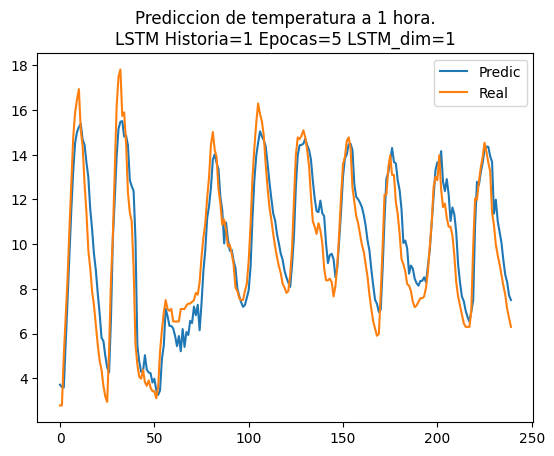

In [74]:
Visualiza ("LSTM")

## LSTM Utilizando una ventana temporal


Una ventana temporal es un segmento fijo de la secuencia de datos. En lugar de alimentar a la LSTM con toda la secuencia de datos de una vez, se divide la secuencia en ventanas más pequeñas. Cada ventana contiene una porción de la secuencia de datos y se utiliza como una entrada independiente para el modelo.
Las ventanas son de 3 elementos. [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] pasaria a [1,2,3], [2,3,4]...

In [76]:
# Preparar los datos para proporcionárselos al modelo
Historia = 3
trainX, trainY = CreaDatos(train, Historia)
testX, testY   = CreaDatos(test, Historia)

In [77]:
print(trainX.shape)
print(trainY.shape)
print(trainX.shape)
print(trainY.shape)

(2147, 3, 6)
(2147, 6)
(2147, 3, 6)
(2147, 6)


In [78]:

# Crear y entrenar la red
model = Sequential()
model.add(LSTM(LSTM_dim, input_shape=(trainX.shape [1], trainX.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY[:,3], epochs=EPOCAS, batch_size=BATCHSIZE, verbose=2)


Epoch 1/5
2147/2147 - 10s - loss: 0.0182 - 10s/epoch - 5ms/step
Epoch 2/5
2147/2147 - 10s - loss: 0.0085 - 10s/epoch - 5ms/step
Epoch 3/5
2147/2147 - 11s - loss: 0.0048 - 11s/epoch - 5ms/step
Epoch 4/5
2147/2147 - 8s - loss: 0.0037 - 8s/epoch - 4ms/step
Epoch 5/5
2147/2147 - 10s - loss: 0.0030 - 10s/epoch - 5ms/step


1057/1057 [==============================] - 6s 5ms/step
Test Score: 1.80 RMSE


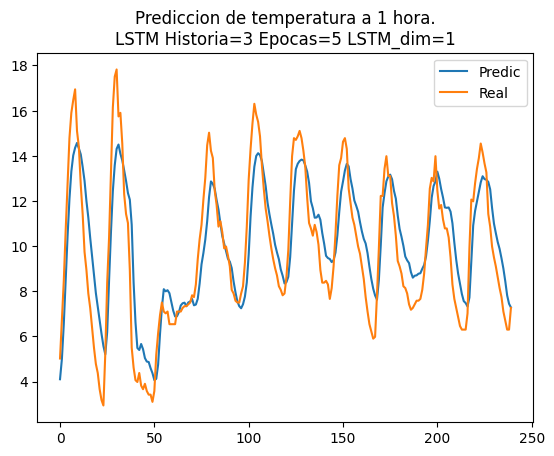

In [79]:
Visualiza("LSTM ventana temporal")

## LSTM apiladas

Se establece una LSTM detrás de otra.

In [80]:
Historia = 1
trainX, trainY = CreaDatos(train, Historia)
testX, testY   = CreaDatos(test, Historia)

In [81]:
print(trainX.shape)
print(trainY.shape)
print(trainX.shape)
print(trainY.shape)

(2149, 1, 6)
(2149, 6)
(2149, 1, 6)
(2149, 6)


In [82]:
# Crear y ajustar la red
model = Sequential()
model.add(LSTM(2, input_shape=(trainX.shape[1],trainX.shape[2]), return_sequences=True))
model.add(LSTM(2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY[:,3], epochs=EPOCAS, batch_size=BATCHSIZE, verbose=2)

Epoch 1/5
2149/2149 - 23s - loss: 0.0149 - 23s/epoch - 11ms/step
Epoch 2/5
2149/2149 - 11s - loss: 0.0031 - 11s/epoch - 5ms/step
Epoch 3/5
2149/2149 - 16s - loss: 0.0017 - 16s/epoch - 7ms/step
Epoch 4/5
2149/2149 - 15s - loss: 0.0014 - 15s/epoch - 7ms/step
Epoch 5/5
2149/2149 - 12s - loss: 0.0012 - 12s/epoch - 6ms/step


1059/1059 [==============================] - 4s 3ms/step
Test Score: 1.16 RMSE


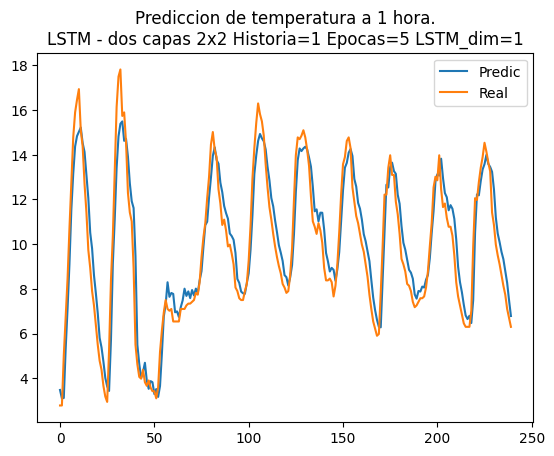

In [83]:
Visualiza ("LSTM - dos capas 2x2")

## LSTM con memoria entre lote y lote



La memoria entre lote y lote se refiere a la capacidad de la LSTM para retener el estado de su memoria entre lotes sucesivos durante el entrenamiento o la predicción. En una LSTM stateful, el estado de la celda y el estado oculto se transfieren de un lote al siguiente. Esto es útil en problemas donde la secuencia de datos es larga y no se puede procesar toda de una vez, pero se necesita mantener la continuidad temporal a lo largo de los lotes. En otras palabras, la LSTM "recuerda" el contexto de la secuencia de datos anterior al procesar la siguiente porción de datos.

In [84]:
batch_size = 1

In [85]:
# Crear y entrenar la red
model = Sequential()
model.add(LSTM(LSTM_dim, batch_input_shape=(batch_size, trainX.shape [1], trainX.shape [2]), stateful=True))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(EPOCAS):
    model.fit(trainX, trainY[:,3], epochs=1, batch_size=BATCHSIZE, verbose=2, shuffle=False)
    model.reset_states()


2149/2149 - 11s - loss: 0.0200 - 11s/epoch - 5ms/step
2149/2149 - 7s - loss: 0.0119 - 7s/epoch - 3ms/step
2149/2149 - 7s - loss: 0.0079 - 7s/epoch - 3ms/step
2149/2149 - 8s - loss: 0.0057 - 8s/epoch - 4ms/step
2149/2149 - 8s - loss: 0.0042 - 8s/epoch - 4ms/step


1059/1059 [==============================] - 7s 6ms/step
Test Score: 2.25 RMSE


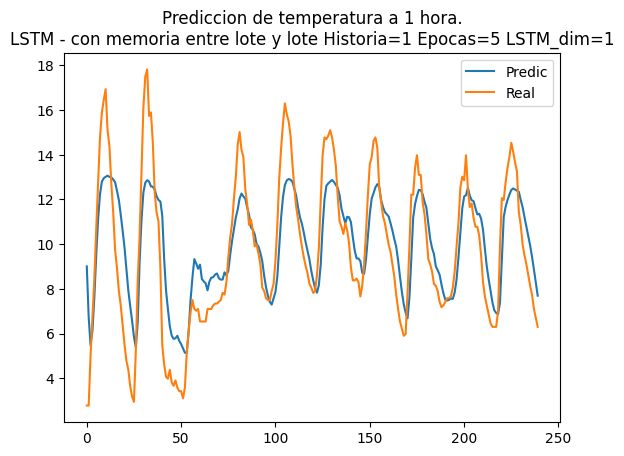

In [86]:
Visualiza ("LSTM - con memoria entre lote y lote")

## LSTM's apiladas (varias capas) con memoria entre lote y lote


In [87]:
batch_size = 1

In [88]:
# Crear y ajustar la red
model = Sequential()
model.add(LSTM(2, batch_input_shape=(batch_size, trainX.shape[1], trainX.shape[2]), stateful=True, return_sequences=True))
model.add(LSTM(2, batch_input_shape=(batch_size, trainX.shape[1], trainX.shape[2]), stateful=True))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(EPOCAS):
    model.fit(trainX, trainY[:,3], epochs=1, batch_size=BATCHSIZE, verbose=2, shuffle=False)
    model.reset_states()

2149/2149 - 15s - loss: 0.0141 - 15s/epoch - 7ms/step
2149/2149 - 15s - loss: 0.0128 - 15s/epoch - 7ms/step
2149/2149 - 15s - loss: 0.0098 - 15s/epoch - 7ms/step
2149/2149 - 15s - loss: 0.0069 - 15s/epoch - 7ms/step
2149/2149 - 10s - loss: 0.0047 - 10s/epoch - 5ms/step


1059/1059 [==============================] - 3s 2ms/step
Test Score: 2.62 RMSE


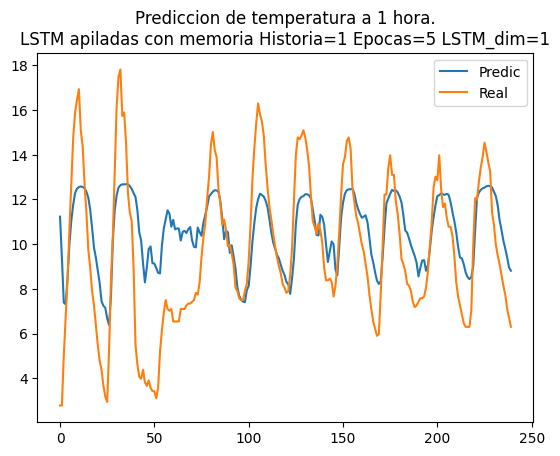

In [93]:
Visualiza ("LSTM apiladas con memoria")